# Variational Autoencoder on Tabular Data

I use [wine dataset](https://archive.ics.uci.edu/ml/datasets/wine) to show how Variational Autoencoder (VAE) with PyTorch on tabular data works. I use the VAE to reduce the dimensionality of dataset, in this case don to 3 Variables (embeddings). I then plot the embeddings in a 3D graph to show how VAE is similar to a PCA but works in a non-linear way. 

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Define Path to Dataset

In [3]:
DATA_PATH = 'Data/wine.csv'

# Define Functions

In [4]:
def load_data(path):
    # read in from csv
    df = pd.read_csv(path, sep=',')
    # replace nan with -99
    df = df.fillna(-99)
    df_base = df.iloc[:, 1:]
    df_wine = df.iloc[:,0].values
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
    # stadardize values
    standardizer = preprocessing.StandardScaler()
    x_train = standardizer.fit_transform(x)
    x_train = torch.from_numpy(x_train).to(device)
    return x_train, standardizer, df_wine

# Build DataLoader

In [5]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path):
        self.x, self.standardizer, self.wine = load_data(DATA_PATH)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [6]:
data_set=DataBuilder(DATA_PATH)
trainloader=DataLoader(dataset=data_set,batch_size=1024)

In [7]:
type(trainloader.dataset.x)

torch.Tensor

In [8]:
data_set.x

tensor([[ 1.5186, -0.5622,  0.2321,  ...,  0.3622,  1.8479,  1.0130],
        [ 0.2463, -0.4994, -0.8280,  ...,  0.4061,  1.1134,  0.9652],
        [ 0.1969,  0.0212,  1.1093,  ...,  0.3183,  0.7886,  1.3951],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ..., -1.6121, -1.4854,  0.2806],
        [ 0.2092,  0.2277,  0.0127,  ..., -1.5683, -1.4007,  0.2965],
        [ 1.3951,  1.5832,  1.3652,  ..., -1.5244, -1.4289, -0.5952]])

# Build Model and train it

In [9]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
#         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
#        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

#         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
#         self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
#         self.fc_bn4 = nn.BatchNorm1d(H2)
        
#         # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.fc1(lin3))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc3(z))
        fc4 = self.relu(self.fc4(fc3))#.view(128, -1)

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # self.decode(z) ist später recon_batch, mu ist mu und logvar ist logvar
        return self.decode(z), mu, logvar

In [10]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [11]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [12]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
#model.apply(weights_init_uniform_rule)
#sae.fc4.register_forward_hook(get_activation('fc4'))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
loss_mse = customLoss()

# Train

In [14]:
epochs = 2000
log_interval = 50
val_losses = []
train_losses = []

In [15]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#        if batch_idx % log_interval == 0:
#            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * len(data), len(trainloader.dataset),
#                       100. * batch_idx / len(trainloader),
#                       loss.item() / len(data)))
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [16]:
for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 200 Average loss: 11.2040
====> Epoch: 400 Average loss: 9.4026
====> Epoch: 600 Average loss: 8.1786
====> Epoch: 800 Average loss: 7.7224
====> Epoch: 1000 Average loss: 7.6587
====> Epoch: 1200 Average loss: 7.4626
====> Epoch: 1400 Average loss: 7.4643
====> Epoch: 1600 Average loss: 7.3207
====> Epoch: 1800 Average loss: 7.0685
====> Epoch: 2000 Average loss: 7.2222


# Evaluate

In [17]:
standardizer = trainloader.dataset.standardizer

In [18]:
model.eval()
test_loss = 0
# no_grad() bedeutet wir nehmen die vorher berechneten Gewichte und erneuern sie nicht
with torch.no_grad():
    for i, data in enumerate(trainloader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)

In [19]:
standardizer.inverse_transform(recon_batch[65].cpu().numpy())

array([1.34402313e+01, 1.96345377e+00, 2.62067842e+00, 1.87440109e+01,
       1.07427719e+02, 2.63568044e+00, 2.69742918e+00, 3.28377843e-01,
       1.67999256e+00, 4.58271646e+00, 1.10575414e+00, 3.02566600e+00,
       1.01869727e+03], dtype=float32)

In [20]:
standardizer.inverse_transform(data[65].cpu().numpy())

array([1.237e+01, 1.210e+00, 2.560e+00, 1.810e+01, 9.800e+01, 2.420e+00,
       2.650e+00, 3.700e-01, 2.080e+00, 4.600e+00, 1.190e+00, 2.300e+00,
       6.780e+02], dtype=float32)

# Get Embeddings

In [21]:
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            
            mu_tensor = mu   
            mu_output.append(mu_tensor)
            mu_result = torch.cat(mu_output, dim=0)

            logvar_tensor = logvar   
            logvar_output.append(logvar_tensor)
            logvar_result = torch.cat(logvar_output, dim=0)

In [22]:
mu_result.shape

torch.Size([178, 3])

In [23]:
mu_result[1:5,:]

tensor([[-0.0331,  1.1830, -0.0299],
        [-0.0395,  1.1291, -0.0380],
        [ 0.0049,  1.6027,  0.0214],
        [ 0.0227,  0.6376,  0.0077]])

# Plot Embeddings

In [24]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

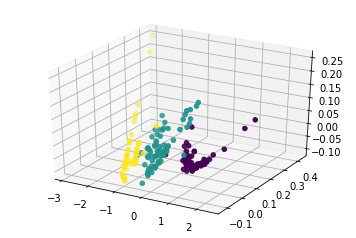

In [25]:
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
winetype = data_set.wine
zdata = mu_result[:,0].numpy()
xdata = mu_result[:,1].numpy()
ydata = mu_result[:,2].numpy()
ax.scatter3D(xdata, ydata, zdata, c=winetype);